In [1]:
import os
import pathlib

from typing import Union, Callable
from datetime import datetime
from functools import partial, lru_cache

import numpy as np
import SimpleITK as sitk
import tensorflow as tf

from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

from matplotlib import pyplot as plt


In [2]:
# Disable tensorflow warnings, shown in jupyter notebook.
tf.get_logger().setLevel('ERROR')

session = datetime.now().strftime("%Y%m%d-%H%M%S")
basedir = pathlib.Path('.').resolve()
distdir = basedir / 'dist' / session
runtime = basedir / 'runtime' / session
dataset = basedir / 'datasets' / 'COVID19'

In [3]:
filereader = sitk.ImageFileReader()
filereader.SetImageIO("NiftiImageIO")


@lru_cache(maxsize=30)
def niiopen(fp: pathlib.Path) -> sitk.Image:
    file_name = str(fp)
    filereader.SetFileName(file_name)

    output = filereader.Execute()
    output = sitk.Cast(output, sitk.sitkFloat32)
    
    return output

In [4]:
def windowize_factory(wl, ww):
    """Creates а function that will rescale input image values
    to range from 0.0 to 1.0.
    """
    wl -= 0.5
    ww -= 1.0
    
    windowizer = sitk.IntensityWindowingImageFilter()
    windowizer.SetOutputMinimum(0.0)
    windowizer.SetOutputMaximum(1.0)
    windowizer.SetWindowMinimum(wl-(ww/2))
    windowizer.SetWindowMaximum(wl+(ww/2))
    
    def windowize(image: sitk.Image):
        output = windowizer.Execute(image)
        output = sitk.Cast(output, sitk.sitkFloat32)
        
        return output
    
    return windowize


In [5]:
def resampler_factory(out_spacing=None, out_size=None, interpolator=sitk.sitkLinear):
    transform = sitk.Transform()
    resampler = sitk.ResampleImageFilter()
    resampler.SetTransform(transform)
    resampler.SetInterpolator(interpolator)
    resampler.SetDefaultPixelValue(0.0)
    
    def resample(image: sitk.Image):
        inputs_size = np.asarray(image.GetSize(), dtype='uint16')
        inputs_spacing = np.asarray(image.GetSpacing(), dtype='float32')
        # Direciton cosine matrix of input image.
        inputs_dcm = np.asarray(image.GetDirection(), dtype='float32')
        inputs_dcm = np.reshape(inputs_dcm, (image.GetDimension(), -1))
        # Imput image origin and center
        inputs_origin = np.asarray(image.GetOrigin(), 'float32')
        inputs_center = np.matmul(inputs_dcm, (inputs_size - 1.0) / 2.0 * inputs_spacing)
        
        ##
        # Calculate output size.
        ##
        if out_size:
            (w, h, *_), d = out_size, inputs_size[2]
            output_size = np.asarray((w, h, d), 'uint16')
        else:
            output_size = inputs_size
        
        resampler.SetSize(output_size.tolist())
        
        ##
        # Calculate output spacing.
        ##
        if out_spacing:
            (x, y, *_), z = out_spacing, inputs_spacing[2]
            output_spacing = np.asarray((x, y, z), dtype='float32')
        else:
            output_spacing = inputs_spacing * (inputs_size / output_size)
        
        resampler.SetOutputSpacing(output_spacing.tolist())
        
        # Calculate output image center and origin.
        output_center = np.matmul(inputs_dcm, (output_size - 1.0) / 2.0 * output_spacing)
        output_origin = inputs_origin + (inputs_center - output_center)

        resampler.SetOutputOrigin(output_origin.tolist())
        resampler.SetOutputDirection(inputs_dcm.reshape(-1).tolist())

        return resampler.Execute(image)
    
    return resample


def resample_as(image: sitk.Image, reference: sitk.Image, interpolator=sitk.sitkLinear):
    """Helper function that resamples the image to parameters as reference image has."""
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(reference)
    resampler.SetInterpolator(interpolator)
    resampler.SetDefaultPixelValue(0.0)
    
    return resampler.Execute(image)


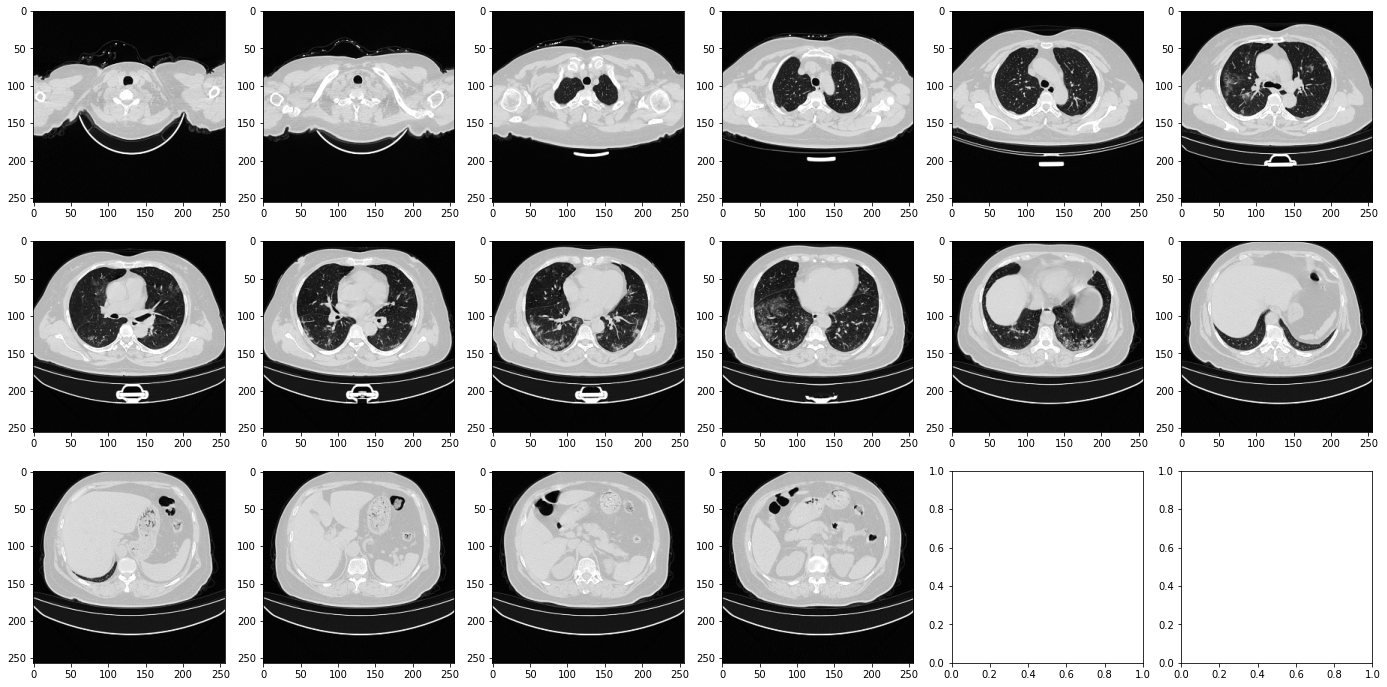

In [6]:
demo_resampler = resampler_factory((1.5, 1.5), (256, 256), interpolator=sitk.sitkLinear)
demo_windowize = windowize_factory(wl=-500, ww=1500)

demo_img = niiopen(dataset / 'cases' / 'coronacases_001.nii.gz')
demo_img = demo_windowize(demo_img)
demo_img = demo_resampler(demo_img)

demo_arr = sitk.GetArrayFromImage(demo_img)
demo_arr = np.rot90(demo_arr[::20], 2)


def plot_demo(arr: np.ndarray):
    ncols = 6
    nrows = -(-arr.shape[0] // ncols)
    
    fig, ax = plt.subplots(nrows, ncols, figsize=4 * np.array([ncols, nrows]))
    for i, a in enumerate(arr):
        ncol = i // ncols
        nrow = i - (ncols * ncol)
        ax[ncol, nrow].imshow(a, cmap='gray')
    plt.show()


plot_demo(demo_arr)

In [7]:
inputs_windowize = windowize_factory(wl=-500, ww=1500)
# Create resamplers: the first one resizes the input image to defined size and spacing, and 
# the second one resamples labels (mask) as a reference (input) image.
inputs_resampler = resampler_factory((1.5, 1.5), (256, 256), interpolator=sitk.sitkLinear)
labels_resampler = partial(resample_as, interpolator=sitk.sitkNearestNeighbor)

def make_dataset(filenames):
    """Makes a dataset for training and validation."""
    inputs_dtype = np.float32
    inputs_shape = (256, 256, 1)
    
    labels_dtype = np.float32
    labels_shape = (256, 256, 4)

    def inputs():
        for filename in filenames:
            inputs = niiopen(inputs_path / filename)
            inputs = inputs_windowize(inputs)
            inputs = inputs_resampler(inputs)
            
            labels = niiopen(labels_path / filename)
            labels = labels_resampler(labels, inputs)

            for x, y in zip(cast_inputs(inputs), cast_labels(labels)):
                # Skip step if all labels represent backgroud.
                if np.all(y[..., 0] == 1.):
                    continue
                yield np.rot90(x, 2), np.rot90(y, 2)

    dtypes = inputs_dtype, labels_dtype
    shapes = inputs_shape, labels_shape
    return tf.data.Dataset.from_generator(inputs, dtypes, shapes)


def cast_inputs(inputs: sitk.Image):
    """Prepares CT scans. The input image MUST be scaled to Hounsfield
    Units (HU) to perform windowing operations."""
    width, height, depth = inputs.GetSize()
    for array in sitk.GetArrayFromImage(inputs):
        output = np.zeros((width, height, 1), np.float32)
        output[..., 0] = array
        yield output

        
def cast_labels(labels: sitk.Image):
    """Preforms a one-hot-encode for labels. Contributions are labeling
    left lung (1), right lung (2) in each CT scan."""
    width, height, depth = labels.GetSize()
    for array in sitk.GetArrayFromImage(labels):
        output = np.zeros((width, height, 4), np.float32)
        np.place(output[..., 0], array == 0., 1.)  # Backgrounds
        np.place(output[..., 1], array == 1., 1.)  # Lung (L)
        np.place(output[..., 2], array == 2., 1.)  # Lung (R)
        np.place(output[..., 3], array == 3., 1.)  # COVID-19
        yield output


In [8]:
def bcdu_net_d3(input_size=(512, 512, 1)):
    inputs, (W, H, D) = Input(input_size), input_size

    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5_1 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5_1 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5_1)
    drop5_1 = Dropout(0.5)(conv5_1)

    conv5_2 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(drop5_1)
    conv5_2 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5_2)
    drop5_2 = Dropout(0.5)(conv5_2)

    merge_dense = concatenate([drop5_1, drop5_2], axis=3)
    
    conv5_3 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge_dense)
    conv5_3 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5_3)
    drop5_3 = Dropout(0.5)(conv5_3)

    up6 = Conv2DTranspose(512, 2, strides=2, padding='same', kernel_initializer='he_normal')(drop5_3)
    up6 = BatchNormalization(axis=3)(up6)
    up6 = Activation('relu')(up6)
    
    x1 = Reshape((1, np.int32(W/8), np.int32(H/8), 512))(drop4)
    x2 = Reshape((1, np.int32(W/8), np.int32(H/8), 512))(up6)
    merge6 = concatenate([x1, x2], axis=1)
    merge6 = ConvLSTM2D(256, 3, padding='same', go_backwards=True, kernel_initializer='he_normal')(merge6)
    
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2DTranspose(256, 2, strides=2, padding='same', kernel_initializer='he_normal')(conv6)
    up7 = BatchNormalization(axis=3)(up7)
    up7 = Activation('relu')(up7)
    
    x1 = Reshape((1, np.int32(W/4), np.int32(H/4), 256))(conv3)
    x2 = Reshape((1, np.int32(W/4), np.int32(H/4), 256))(up7)
    merge7 = concatenate([x1, x2], axis=1)
    merge7 = ConvLSTM2D(128, 3, padding='same', go_backwards=True, kernel_initializer='he_normal')(merge7)
    
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2DTranspose(128, 2, strides=2, padding='same', kernel_initializer='he_normal')(conv7)
    up8 = BatchNormalization(axis=3)(up8)
    up8 = Activation('relu')(up8)
    
    x1 = Reshape((1, np.int32(W/2), np.int32(H/2), 128))(conv2)
    x2 = Reshape((1, np.int32(W/2), np.int32(H/2), 128))(up8)
    merge8 = concatenate([x1, x2], axis=1)
    merge8 = ConvLSTM2D(64, 3, padding='same', go_backwards=True, kernel_initializer='he_normal')(merge8)
    
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2DTranspose(64, 2, strides=2, padding='same', kernel_initializer='he_normal')(conv8)
    up9 = BatchNormalization(axis=3)(up9)
    up9 = Activation('relu')(up9)
    
    x1 = Reshape((1, W, H, 64))(conv1)
    x2 = Reshape((1, W, H, 64))(up9)
    merge9 = concatenate([x1, x2], axis=1)
    merge9 = ConvLSTM2D(32, 3, padding='same', go_backwards=True, kernel_initializer='he_normal')(merge9)
    
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2,  3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    
    # Per-pixel classification layer.
    outputs = Conv2D(4, (1, 1), activation='softmax', dtype=tf.float32)(conv9)

    return Model(inputs=inputs, outputs=outputs, name='bcdu_net_d3')

In [9]:
def iou_fn(class_weights):
    if not isinstance(class_weights, tf.Tensor):
        class_weights = tf.constant(class_weights)
    
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float64)
        y_pred = tf.cast(y_pred, tf.float64)
        
        inter = tf.multiply(class_weights, y_true * y_pred)
        inter = K.sum(inter, axis=-1)
        union = tf.multiply(class_weights, y_true**2 + y_pred**2 - y_true * y_pred)
        union = K.sum(union, axis=-1)
        
        return 1 - (inter / union)

    loss.__name__ = 'iou'
    return loss

In [10]:
def dsc_fn(class_weights):
    if not isinstance(class_weights, tf.Tensor):
        class_weights = tf.constant(class_weights)
    
    def loss(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
        y_true = tf.cast(y_true, tf.float64)
        y_pred = tf.cast(y_pred, tf.float64)
        
        inter = tf.multiply(class_weights, y_true * y_pred)
        inter = K.sum(inter, axis=[1, 2, 3])
        union = tf.multiply(class_weights, y_true + y_pred)
        union = K.sum(union, axis=[1, 2, 3])
        
        return 1 - (2. * inter / union)

    loss.__name__ = 'dsc'
    return loss


In [11]:
def compute_class_weights(dataset: tf.data.Dataset):
    """Estimates class weights for unbalanced datasets."""
    labels = np.stack(list([y for _, y in dataset.as_numpy_iterator()]))
    labels = np.argmax(labels, axis=-1)
    
    unique, counts = np.unique(labels, return_counts=True)
    n_classes = len(unique)
    n_samples = sum(counts)
    
    return n_samples / (n_classes * counts)


In [12]:
batch_size = 8
files_tplt = 'coronacases_{:03d}.nii.gz'

inputs_path = dataset / 'cases'
labels_path = dataset / 'masks' / 'lungs_and_infection'

# Create a training dataset (001-008) and validation one (009-010).
fit_data = make_dataset([files_tplt.format(i) for i in range(1,  9)])
val_data = make_dataset([files_tplt.format(i) for i in range(9, 11)])


In [13]:
# Free up RAM in case the model definition cells were run multiple times
K.clear_session()

# Use half precision.
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_policy(policy)

# For training on multiple GPUs installed on a single machine.
strategy = tf.distribute.MirroredStrategy(
    # The `tf.distribute.NcclAllReduce()` is not supported on Windows 10.
    cross_device_ops=tf.distribute.HierarchicalCopyAllReduce()
)

with strategy.scope():
    # Compute class weights.
    class_weights = compute_class_weights(fit_data)
    class_weights = tf.constant(class_weights / max(class_weights))
    print(class_weights)
    
    # Create losses.
    iou = iou_fn(class_weights)
    dsc = dsc_fn(class_weights)
    
    # Create optimizer.
    optimizer = Adam(lr=1e-4)
    
    # Everything that creates variables should be under the strategy scope.
    # In general this is only model building & `compile()`.
    model = bcdu_net_d3(input_size=(256, 256, 1))
    model.compile(optimizer, loss=iou, metrics=[iou, dsc])


tf.Tensor([0.00823114 0.1549799  0.13424406 1.        ], shape=(4,), dtype=float64)


In [14]:
model_ckpt_path = runtime / 'ckpts'
model_ckpt_name = 'ckpt-{epoch:02d}-{val_loss:.4f}'
model_ckpt = ModelCheckpoint(
    filepath=model_ckpt_path / model_ckpt_name,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=0
)

# Ensure the parent directoy for checkpoints exists.
if not model_ckpt_path.exists():
    model_ckpt_path.mkdir(parents=True, exist_ok=True)


In [ ]:
fit_batches = fit_data.batch(batch_size)
val_batches = val_data.batch(batch_size)

# Train the model on all available devices.
history = model.fit(fit_batches, validation_data=val_batches, epochs=100, callbacks=[
    model_ckpt,
])

# Save model in tensorflow format.
model.save(distdir, save_format='tf')

Epoch 1/100
216/216 [==============================] - 81s 375ms/step - loss: 0.4775 - iou: 0.4775 - dsc: 0.7133 - val_loss: 0.0777 - val_iou: 0.0777 - val_dsc: 0.4869
Epoch 2/100
216/216 [==============================] - 76s 350ms/step - loss: 0.1093 - iou: 0.1093 - dsc: 0.5288 - val_loss: 0.0770 - val_iou: 0.0770 - val_dsc: 0.4797
Epoch 3/100
216/216 [==============================] - 75s 348ms/step - loss: 0.1093 - iou: 0.1093 - dsc: 0.5283 - val_loss: 0.0770 - val_iou: 0.0770 - val_dsc: 0.4792
Epoch 4/100
216/216 [==============================] - 75s 349ms/step - loss: 0.1093 - iou: 0.1093 - dsc: 0.5281 - val_loss: 0.0770 - val_iou: 0.0770 - val_dsc: 0.4790
Epoch 5/100
216/216 [==============================] - 75s 349ms/step - loss: 0.1093 - iou: 0.1093 - dsc: 0.5280 - val_loss: 0.0770 - val_iou: 0.0770 - val_dsc: 0.4790
Epoch 6/100
216/216 [==============================] - 76s 350ms/step - loss: 0.1093 - iou: 0.1093 - dsc: 0.5280 - val_loss: 0.0770 - val_iou: 0.0770 - val_dsc:

216/216 [==============================] - 74s 343ms/step - loss: 0.1093 - iou: 0.1093 - dsc: 0.5280 - val_loss: 0.0770 - val_iou: 0.0770 - val_dsc: 0.4789
Epoch 50/100
216/216 [==============================] - 74s 343ms/step - loss: 0.1093 - iou: 0.1093 - dsc: 0.5280 - val_loss: 0.0770 - val_iou: 0.0770 - val_dsc: 0.4789
Epoch 51/100
216/216 [==============================] - 74s 343ms/step - loss: 0.1093 - iou: 0.1093 - dsc: 0.5280 - val_loss: 0.0770 - val_iou: 0.0770 - val_dsc: 0.4789
Epoch 52/100
216/216 [==============================] - 74s 343ms/step - loss: 0.1093 - iou: 0.1093 - dsc: 0.5280 - val_loss: 0.0770 - val_iou: 0.0770 - val_dsc: 0.4789
Epoch 53/100
216/216 [==============================] - 74s 343ms/step - loss: 0.1093 - iou: 0.1093 - dsc: 0.5280 - val_loss: 0.0770 - val_iou: 0.0770 - val_dsc: 0.4789
Epoch 54/100
216/216 [==============================] - 74s 342ms/step - loss: 0.1093 - iou: 0.1093 - dsc: 0.5280 - val_loss: 0.0770 - val_iou: 0.0770 - val_dsc: 0.4789

In [ ]:
# Plot training and validation loss.
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.ylabel('Value')
plt.xlabel('No. epoch')
plt.legend(loc='upper right')
plt.show()

In [ ]:
ckpt = tf.train.latest_checkpoint(model_ckpt_path)
print("Latest checkpoint is", ckpt)

del model

K.clear_session()
model = load_model(distdir, custom_objects={'dsc': dsc, 'iou': iou})
model.load_weights(ckpt)

In [ ]:
dcmreader = sitk.ImageSeriesReader()
dcmreader.SetImageIO("GDCMImageIO")

def dcmopen(fp) -> sitk.Image:
    filenames = dcmreader.GetGDCMSeriesFileNames(str(fp))
    dcmreader.SetFileNames(filenames)
    
    output = dcmreader.Execute()
    output = sitk.Cast(output, sitk.sitkFloat32)
    return output


series = dcmopen(basedir / 'datasets' / 'DICOM' / 'example-1')

img_x = inputs_windowize(series)
img_x = inputs_resampler(img_x)

def generate_inputs():
    for x in cast_inputs(img_x):
        yield x
        
x = tf.data.Dataset.from_generator(generate_inputs, np.float32, (256, 256, 1)).batch(batch_size)
y = model.predict(x)
y = to_categorical(np.argmax(y, axis=-1), num_classes=4)

img_y = sitk.GetImageFromArray(y)
img_y.CopyInformation(img_x)

result = resample_as(img_y, series)

In [ ]:
arr_x = sitk.GetArrayFromImage(series)
arr_y = sitk.GetArrayFromImage(result)


def plot_results(array0, array1):
    ncols = 4
    nrows = array0.shape[0]
    
    fig, ax = plt.subplots(nrows, ncols, figsize=4 * np.array([ncols, nrows]))
    for nrow, (arr0, arr1) in enumerate(zip(array0, array1)):
        ax[nrow, 0].imshow(arr0, cmap='gray')
        ax[nrow, 1].imshow(arr1[..., 1], cmap='binary')
        ax[nrow, 2].imshow(arr1[..., 2], cmap='binary')
        ax[nrow, 3].imshow(arr1[..., 3], cmap='binary')
    plt.show()


plot_results(arr_x, arr_y)